# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Read Data

In [2]:
data = pd.read_csv('UNRATE.csv', header=None)
data.columns = ['Date', 'Rate']
data.Date = pd.to_datetime(data.Date, format='%d-%m-%Y')
data = data.set_index('Date')
data.head()

,Rate
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [3]:
data.shape

(867, 1)

# Plot Time Series Data

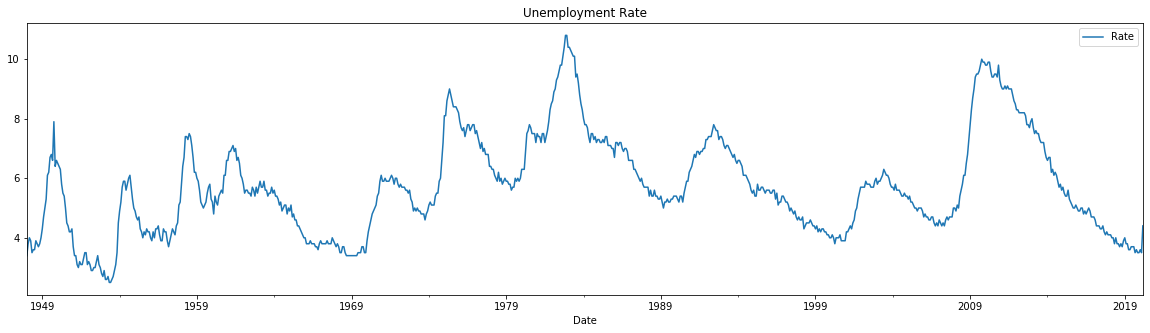

In [4]:
data.plot(figsize=(20,5))
plt.legend(loc='best')
plt.title('Unemployment Rate')
plt.show(block=False)

# Build and Evaluate Time Series Models

## Test-Train Split

In [5]:
data.shape

(867, 1)

In [6]:
train_len = 612
train = data[:train_len]
test = data[train_len:]
print(train.shape)
print(test.shape)

(612, 1)
(255, 1)


## Box Cox Transformation and Differencing

### Before Box Cox

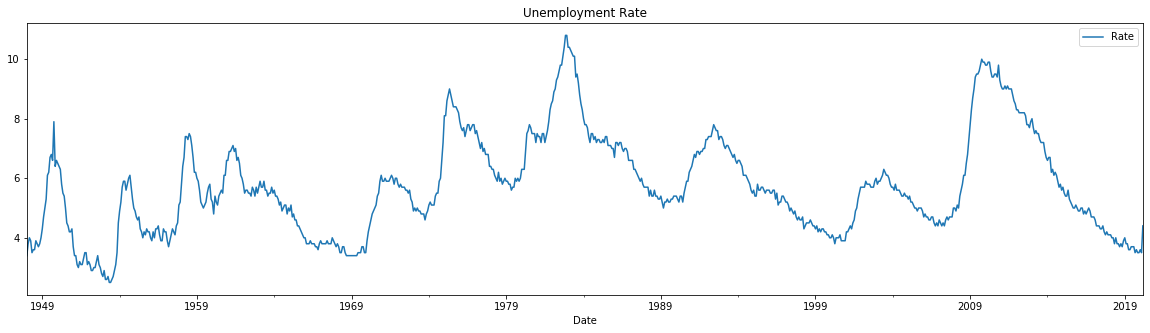

In [7]:
data.plot(figsize=(20,5))
plt.legend(loc='best')
plt.title('Unemployment Rate')
plt.show(block=False)

### After Box Cox

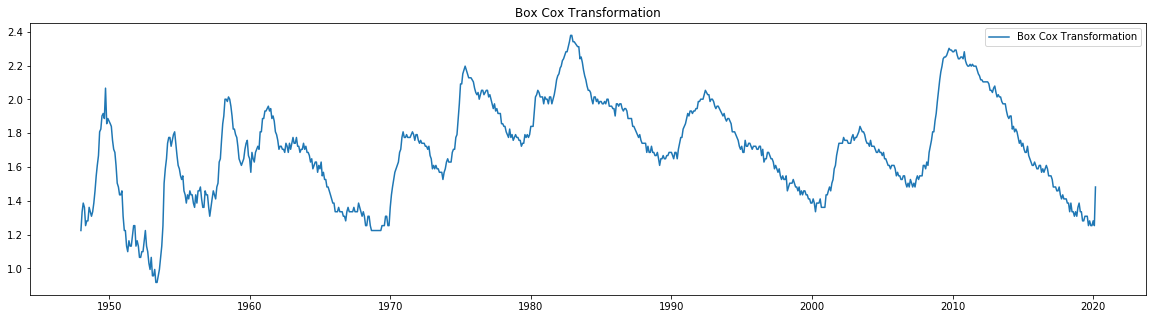

In [8]:
data_boxcox = pd.Series(boxcox(data.Rate, lmbda=0), index = data.index)
plt.figure(figsize=(20,5))
plt.plot(data_boxcox, label='Box Cox Transformation')
plt.legend(loc='best')
plt.title('Box Cox Transformation')
plt.show()

### After Differencing

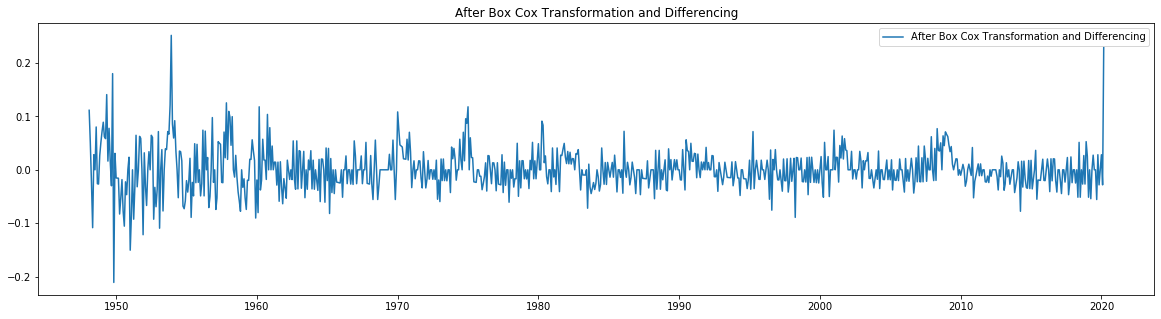

In [9]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index=data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(20,5))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.title('After Box Cox Transformation and Differencing')
plt.show()

## Split Train-Test

In [10]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

## Auto Regressive Method (AR)

### Build AR Model

In [11]:
model = ARIMA(train_data_boxcox_diff, order=(12,0,0))
model_fit = model.fit()
print(model_fit.params)

C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060691
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090456
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047125
ar.L12.y   -0.148533
dtype: float64


### Recover original Time Series Forecast

In [12]:
method = data_boxcox_diff.copy()
method['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
method['ar_forecast_boxcox'] = method['ar_forecast_boxcox_diff'].cumsum()
method['ar_forecast_boxcox'] = method['ar_forecast_boxcox'].add(data_boxcox[0])
method['forecast'] = np.exp(method['ar_forecast_boxcox'])

### Plot train, test and forecast

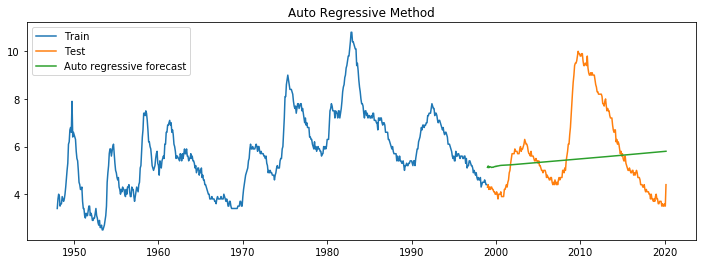

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train.Rate, label='Train')
plt.plot(test.Rate, label='Test')
plt.plot(method['forecast'][test.index.min():], label='Auto regressive forecast')
plt.legend(loc='best')
plt.title('Auto Regressive Method')
plt.show()

### Calculate RMSE and MAPE

In [14]:
rmse = np.sqrt(mean_squared_error(test.Rate, method['forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Rate-method['forecast'][test.index.min():])/test.Rate)*100,2)
accuracy = 100 - mape

results = pd.DataFrame({'Method':['AR Method'], 'RMSE':[rmse], 'MAPE':[mape], 'Accuracy':[accuracy]})
results = results[['Method', 'RMSE', 'MAPE', 'Accuracy']]
results

,Method,RMSE,MAPE,Accuracy
0,AR Method,1.83,23.62,76.38


<font color='blue' size=5>Set 1, Graded Question 1: Answer is 1.83, 23.62</font>

### Prediction of Unemployment Rate in June 1948

In [15]:
round(method['forecast']['1948-06-01'],2)

4.21

<font color='blue' size=5>Set 1, Graded Question 2: Answer is 4.21</font>

## Moving Average Method (MA)

### Build MA Model

In [16]:
model = ARIMA(train_data_boxcox_diff, order=(0,0,5))
model_fit = model.fit()
print(model_fit.params)

C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.000507
ma.L1.y    0.055504
ma.L2.y    0.181882
ma.L3.y    0.123451
ma.L4.y    0.099834
ma.L5.y    0.151700
dtype: float64


### Recover original Time Series Forecast

In [17]:
method = data_boxcox_diff.copy()
method['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
method['ma_forecast_boxcox'] = method['ma_forecast_boxcox_diff'].cumsum()
method['ma_forecast_boxcox'] = method['ma_forecast_boxcox'].add(data_boxcox[0])
method['forecast'] = np.exp(method['ma_forecast_boxcox'])

### Plot train, test and forecast

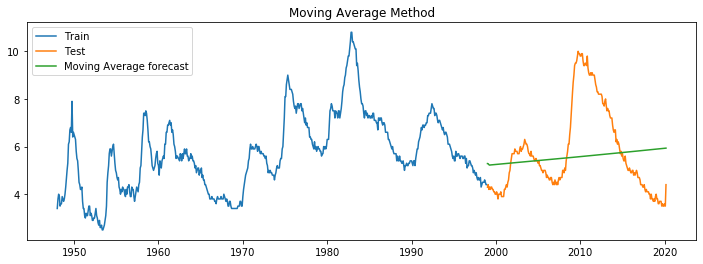

In [18]:
plt.figure(figsize=(12,4))
plt.plot(train.Rate, label='Train')
plt.plot(test.Rate, label='Test')
plt.plot(method['forecast'][test.index.min():], label='Moving Average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [19]:
rmse = np.sqrt(mean_squared_error(test.Rate, method['forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Rate-method['forecast'][test.index.min():])/test.Rate)*100,2)
accuracy = 100 - mape

tempRresults = pd.DataFrame({'Method':['MA Method'], 'RMSE':[rmse], 'MAPE':[mape], 'Accuracy':[accuracy]})
results = pd.concat([results, tempRresults])
results

,Method,RMSE,MAPE,Accuracy
0,AR Method,1.83,23.62,76.38
0,MA Method,1.82,24.26,75.74


### Prediction of Unemployment Rate in June 1948

In [20]:
round(method['forecast']['1948-06-01'],2)

4.14

<font color='blue' size=5>Set 1, Graded Question 3: Answer is 4.14</font>

## Auto Regressive Integrated Moving Average (ARIMA) Method

### Build ARIMA Model

In [21]:
# Note, we are passing train_data_boxcox and not train_data_boxcox_diff because ARIMA
# handles differencing internally. This is the middle parameter we pass in order, called as 'd'
model = ARIMA(train_data_boxcox, order=(12,1,5))
model_fit = model.fit()
print(model_fit.params)

C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const         0.000474
ar.L1.D.y    -0.436416
ar.L2.D.y     0.811796
ar.L3.D.y     0.774879
ar.L4.D.y    -0.551921
ar.L5.D.y    -0.813971
ar.L6.D.y     0.075923
ar.L7.D.y     0.064766
ar.L8.D.y     0.069036
ar.L9.D.y     0.186881
ar.L10.D.y    0.020261
ar.L11.D.y   -0.072671
ar.L12.D.y   -0.068804
ma.L1.D.y     0.465935
ma.L2.D.y    -0.640806
ma.L3.D.y    -0.600943
ma.L4.D.y     0.621929
ma.L5.D.y     0.873827
dtype: float64


C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Recover original Time Series Forecast

In [22]:
method = data_boxcox_diff.copy()
method['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
method['arima_forecast_boxcox'] = method['arima_forecast_boxcox_diff'].cumsum()
method['arima_forecast_boxcox'] = method['arima_forecast_boxcox'].add(data_boxcox[0])
method['forecast'] = np.exp(method['arima_forecast_boxcox'])

### Plot train, test and forecast

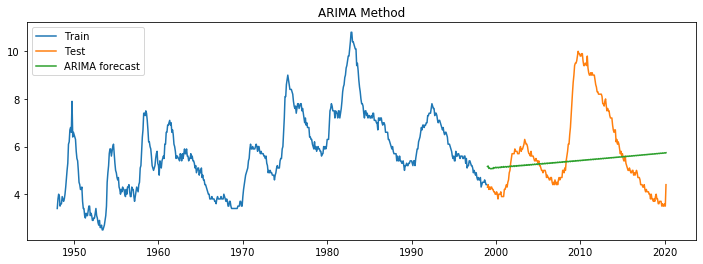

In [23]:
plt.figure(figsize=(12,4))
plt.plot(train.Rate, label='Train')
plt.plot(test.Rate, label='Test')
plt.plot(method['forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

### Calculate RMSE and MAPE

In [24]:
rmse = np.sqrt(mean_squared_error(test.Rate, method['forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Rate-method['forecast'][test.index.min():])/test.Rate)*100,2)
accuracy = 100 - mape

tempRresults = pd.DataFrame({'Method':['ARIMA Method'], 'RMSE':[rmse], 'MAPE':[mape], 'Accuracy':[accuracy]})
results = pd.concat([results, tempRresults])
results

,Method,RMSE,MAPE,Accuracy
0,AR Method,1.83,23.62,76.38
0,MA Method,1.82,24.26,75.74
0,ARIMA Method,1.84,23.31,76.69


<font color='blue' size=5>Set 2, Graded Question 1: Answer is 1.85, 23.23 (approximately same as what I got).</font>

## Seasonal Auto Regressive Integrated Moving Average (SARIMA) Method

### Build SARIMA Model

In [25]:
# Note, we are passing train_data_boxcox and not train_data_boxcox_diff because ARIMA
# handles differencing internally. This is the middle parameter we pass in order, called as 'd'
model = SARIMAX(train_data_boxcox, order=(2,1,4), seasonal_order=(2,1,4,12))
model_fit = model.fit()
print(model_fit.params)

C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\g518846\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ar.L1       0.595356
ar.L2       0.126458
ma.L1      -0.568253
ma.L2      -0.003873
ma.L3       0.063128
ma.L4       0.046530
ar.S.L12   -0.942179
ar.S.L24   -0.509622
ma.S.L12   -0.275755
ma.S.L24   -0.529212
ma.S.L36   -0.404097
ma.S.L48    0.261494
sigma2      0.001480
dtype: float64


### Recover original Time Series Forecast

In [26]:
method = data_boxcox_diff.copy()
method['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
method['forecast'] = np.exp(method['sarima_forecast_boxcox'])

### Plot train, test and forecast

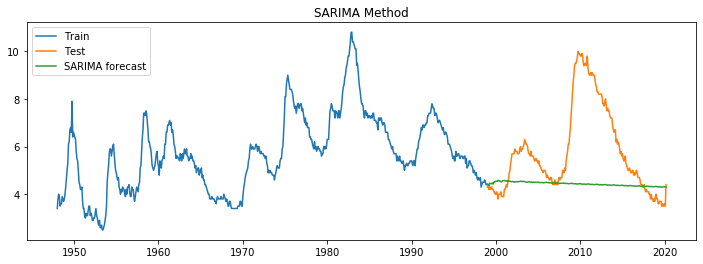

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train.Rate, label='Train')
plt.plot(test.Rate, label='Test')
plt.plot(method['forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA Method')
plt.show()

### Calculate RMSE and MAPE

In [28]:
rmse = np.sqrt(mean_squared_error(test.Rate, method['forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test.Rate-method['forecast'][test.index.min():])/test.Rate)*100,2)
accuracy = 100 - mape

tempRresults = pd.DataFrame({'Method':['SARIMA Method'], 'RMSE':[rmse], 'MAPE':[mape], 'Accuracy':[accuracy]})
results = pd.concat([results, tempRresults])
results

,Method,RMSE,MAPE,Accuracy
0,AR Method,1.83,23.62,76.38
0,MA Method,1.82,24.26,75.74
0,ARIMA Method,1.84,23.31,76.69
0,SARIMA Method,2.25,22.08,77.92


<font color='blue' size=5>Set 2, Graded Question 2: Answer is 2.26, 22.17 (approximately same as what I got).</font>